<a href="https://colab.research.google.com/github/HimashiRathnayake/CMCS-Text-Classification/blob/main/baselines/cnn%20rnn/humor%20hate-speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Hate Speech Detection & Humor Detection for Code-mixed Sinhala-English Data </h1>

# User Parameters

In [ ]:
Host = "colab" #@param ["colab", "AWS", "GCP"]
technique = "humor" #@param ["humor", "hate speech"]

EMBEDDING_SIZE = 300 #@param [50, 150, 200, 250, 300, 350, 400, 450, 500]
embedding_type = "fasttext" #@param ["fasttext","word2vec"]
experiment_no = "801" #@param [] {allow-input: true}
model_type = "LSTM" #@param ["RNN","GRU", "LSTM", "BiLSTM"]
over_sampling_technique = "" #@param ["", "ROS","ADASYN", "SMOTE", "BorderlineSMOTE"]
sampling_strategy = "" #@param [] {allow-input: true}

stack_modeles = "" #@param ["","2","3"]
apply_CNN = False #@param {type:"boolean"}
apply_TPU_support = True #@param {type:"boolean"}

model_name = model_type + "_model"
if(stack_modeles == "2" or stack_modeles == "3"):
  model_name = "stacked_" + model_name + "_" + stack_modeles
if(apply_CNN):
  model_name = "CNN_" + model_name

if technique == "humor" :
  NO_OUTPUT_LAYERS = 2
  tag_set = ["Humorous", "Non-Humorous"]
elif technique == "hate speech":
  NO_OUTPUT_LAYERS = 3
  tag_set = ["Abusive", "Hate-Inducing", "Not offensive"]

print(model_name + " for " + technique + " detection")

LSTM_model for humor detection


# Folder Paths

In [ ]:
folder_path = "/content/drive/Shareddrives/FYP/"
data_path = "/content/drive/Shareddrives/FYP-CodeStars/" + "Annotations/Final/All_tagged_data/çompleted_draft.csv"

context = 5
word_embedding_path = folder_path + "Embedding models/" + embedding_type + '/' + str(EMBEDDING_SIZE) + "/embedding_" + embedding_type + "_" + str(EMBEDDING_SIZE)
word_embedding_keydvectors_path = folder_path + "Embedding models/" + embedding_type + '/' + str(EMBEDDING_SIZE) + "/keyed_vectors/" +  "embedding_" + embedding_type + "_" + str(EMBEDDING_SIZE)
embedding_matrix_path = "/content/drive/Shareddrives/FYP-CodeStars/" + "Humor_HateSpeech detection/Implementation/embedding_matrix/"+embedding_type+'_'+str(EMBEDDING_SIZE)

experiment_name = str(experiment_no) + "_"+ model_name +"_"+embedding_type+"_"+str(EMBEDDING_SIZE)+"_"+str(context)
model_save_path = folder_path + "Humor_HateSpeech detection/Implementation/saved_models/"+technique+"/"+experiment_name+".hdf5"

# Dependencies

In [ ]:
# !pip uninstall keras-nightly
!pip uninstall -y tensorflow
!pip install h5py==2.10.0  
!pip install tensorflow==1.15.2
!pip install q keras==2.3.1

Found existing installation: tensorflow 2.6.0
Uninstalling tensorflow-2.6.0:
  Successfully uninstalled tensorflow-2.6.0
     |████████████████████████████████| 2.9 MB 5.2 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
     |████████████████████████████████| 110.5 MB 36 kB/s 
     |████████████████████████████████| 50 kB 5.7 MB/s 
     |████████████████████████████████| 3.8 MB 37.0 MB/s 
     |████████████████████████████████| 503 kB 59.5 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=c347e7000703c99eeca1580e52f660ab06ba068bcc6d9b4a61c3fed5d8fa3739
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uni

In [ ]:
from __future__ import print_function

import collections
import pickle
import re
import random
import sys
import os 
import time

import gensim
from gensim.models.keyedvectors import KeyedVectors
from gensim.models.fasttext import FastText
from gensim.models import word2vec

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, precision_recall_fscore_support, make_scorer

import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
from numpy import cumsum

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import keras
from keras import backend as K
from keras.models import Sequential,Model,load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dropout, Activation, Flatten, \
    Embedding, Convolution1D, MaxPooling1D, AveragePooling1D, \
    Input, Dense, merge, Add,TimeDistributed, Bidirectional,SpatialDropout1D
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.regularizers import l2, l1_l2
from keras.constraints import maxnorm
from keras import callbacks
from keras.utils import generic_utils,plot_model
from keras.optimizers import Adadelta, Adam, SGD, RMSprop, Adagrad, Adamax, Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

from google.colab import data_table
from google.colab import drive

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


**Add TPU Support**

In [ ]:
if (apply_TPU_support):

  print("Tensorflow version " + tf.__version__)

  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
  except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

  tf.config.experimental_connect_to_cluster(tpu)
  # tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 1.15.2
Running on TPU  ['10.112.255.90:8470']
INFO:tensorflow:Querying Tensorflow master (grpc://10.112.255.90:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 4957849525897187462)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 913125345495667817)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 6468003396872251072)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 6807787747355436272)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 13339893453432938295)


# Load Data

In [ ]:
all_data = pd.read_csv(data_path)

if (technique == "humor"):
  all_data = all_data[['Sentence', 'Humor']]
elif (technique == "hate speech"):
  all_data = all_data[['Sentence', 'Hate_speech']]
else:
  all_data = all_data[['Sentence', 'Offensive']]

all_data.columns = ['Sentence', 'Label']
data_table.DataTable(all_data, include_index=False, num_rows_per_page=10)

,Sentence,Label
0,Ammage Adarayta❤️Eka Dawasak Madi Neda❤️🙏❤️,Not offensive
1,We need IPL Champions leak data offers ..pleas...,Not offensive
2,#VPN #ummmaaa #proud_be,Not offensive
3,chandimal.. uuu thama mulu tem ekama kaaa gaha...,Not offensive
4,sltgo,Not offensive
...,...,...
13513,Me mase web family plus packge eke total eka 6...,Not offensive
13514,munge Dan data kapana widiye awulk thiyenwa,Abusive
13515,I didn't received loyalty data past months. Pl...,Not offensive
13516,worst service ever!!! stolen more than 10GB fr...,Not offensive


In [ ]:
output_labels = all_data['Label'].unique()
print('Output Labels:', output_labels)

label_group =  all_data.groupby('Label')['Label'].count()
print(label_group)

Output Labels: ['Not offensive' 'Hate-Inducing' 'Abusive']
Label
Abusive            908
Hate-Inducing      348
Not offensive    12262
Name: Label, dtype: int64


# Create Input

## Comment-label split

In [ ]:
def text_preprocessing(data):
  comments = data['Sentence']
  labels = data['Label']

  comments_splitted = []

  for comment in comments:
    lines = []
    try:
      words = comment.split()
      lines += words
    except:
      continue
    comments_splitted.append(lines)

  return comments_splitted,labels

## Takenize and Split Data

In [ ]:
comment_texts, comment_labels = text_preprocessing(all_data)

# prepare tokenizer

t = Tokenizer()
t.fit_on_texts(comment_texts)
vocab_size = len(t.word_index) + 1
print(vocab_size)

28401


In [ ]:
encoded_docs = t.texts_to_sequences(comment_texts)

In [ ]:
max_length = len(max(encoded_docs, key=len))
padded_docs = pad_sequences(encoded_docs, maxlen=max_length)
comment_labels = np.array(comment_labels)
padded_docs = np.array(padded_docs)

In [ ]:
comment_labels = pd.get_dummies(comment_labels).values
print('Shape of label tensor:', comment_labels.shape)

Shape of label tensor: (13518, 3)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_docs, comment_labels, test_size=0.1, random_state=0)

## Oversampling

In [ ]:
def apply_oversampling(x, y):

  (unique, counts) = np.unique(y, axis=0, return_counts=True)
  print("Class Distribution Without Oversampling", counts)

  # define oversampling strategy
  if (over_sampling_technique == ""):
    return x, y
  elif (over_sampling_technique == "ROS"):
    if (technique=="humor"):
      oversample = RandomOverSampler(sampling_strategy = float(sampling_strategy))
    else:
      sampling_ratio = sampling_strategy.split(":");
      oversample = RandomOverSampler(ratio = {
          0:int(counts[0]*float(sampling_ratio[0])), 
          1:int(counts[0]*float(sampling_ratio[1])), 
          2:int(counts[0]*float(sampling_ratio[2]))
          })
  elif (over_sampling_technique == "ADASYN"):
    oversample = ADASYN(sampling_strategy="minority")
  elif (over_sampling_technique == "SMOTE"):
    oversample = SMOTE()
  elif (over_sampling_technique == "BorderlineSMOTE"):
    oversample = BorderlineSMOTE()

  # fit and apply the transform
  X_over, y_over = oversample.fit_resample(x, y)
  if(technique=="humor"):
    y_over = pd.get_dummies(y_over.flatten())

  (unique, counts) = np.unique(y_over, axis=0, return_counts=True)
  print("Class Distribution After Oversampling", counts)

  return X_over, y_over

# Word Embedding

## Generate Embedding Metrix

In [ ]:
def generate_embedding_metrix():
  if (embedding_type == 'fasttext'):
    word_embedding_model = FastText.load(word_embedding_path)
  else:
    word_embedding_model = word2vec.Word2Vec.load(word_embedding_path)
    
  word_vectors = word_embedding_model.wv
  word_vectors.save(word_embedding_keydvectors_path)
  word_vectors = KeyedVectors.load(word_embedding_keydvectors_path, mmap='r')

  embeddings_index = dict()
  for word, vocab_obj in word_vectors.vocab.items():
    embeddings_index[word]=word_vectors[word]

  # create a weight matrix for words in training docs
  embedding_matrix = zeros((vocab_size, EMBEDDING_SIZE))
  for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

  pickle.dump(embedding_matrix, open(embedding_matrix_path, 'wb'))
  return embedding_matrix

## Load Embedding Matrix

In [ ]:
def load_word_embedding_matrix():
  f = open(embedding_matrix_path, 'rb')
  embedding_matrix= np.array(pickle.load(f))
  return embedding_matrix

# Models

## RNN(LSTM/GRU) model

In [ ]:
def RNN_model(RNN_layer, maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2, optimizer="Adadelta"):
    main_input = Input(shape=(maxlen, ), dtype='int32', name='main_input')
    embedding  = Embedding(MAX_FEATURES, EMBEDDING_SIZE,
                  weights=[EMBEDDING_MATRIX], input_length=maxlen,
                  name='embedding' ,trainable=False)(main_input)

    embedding = Dropout(drop_out_value_1)(embedding)

    x = RNN_layer(hidden_dims)(embedding)

    x = Dense(hidden_dims, activation='relu', init='he_normal', 
              W_constraint = maxnorm(3), b_constraint=maxnorm(3),
              name='mlp')(x)

    x = Dropout(drop_out_value_2, name='drop')(x)

    output = Dense(NO_OUTPUT_LAYERS, init='he_normal',
                   activation='softmax', name='output')(x)

    model = Model(input=main_input, output=output ,name="RNN_model")

    if optimizer == "Adadelta":
        optimizer = Adadelta(lr=0.95, epsilon=1e-06)

    model.compile(loss={'output':'categorical_crossentropy'},
              optimizer = optimizer,
              metrics=["accuracy", 
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       f1
                       ])
    
    print(model.summary())
    return model

def stacked_RNN_model_2(RNN_layer, maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2):
    main_input = Input(shape=(maxlen, ), dtype='int32', name='main_input')
    embedding  = Embedding(MAX_FEATURES, EMBEDDING_SIZE,
                  weights=[EMBEDDING_MATRIX], input_length=maxlen,
                  name='embedding' ,trainable=False)(main_input)

    embedding = Dropout(drop_out_value_1)(embedding)

    x = RNN_layer(hidden_dims,return_sequences=True)(embedding)
    x = RNN_layer(hidden_dims)(x)

    x = Dense(hidden_dims, activation='relu', init='he_normal',
              W_constraint = maxnorm(3), b_constraint=maxnorm(3),
              name='mlp')(x)

    x = Dropout(drop_out_value_2, name='drop')(x)

    output = Dense(NO_OUTPUT_LAYERS, init='he_normal',
                   activation='softmax', name='output')(x)

    model = Model(input=main_input, output=output, name= "stacked_RNN_model_2")

    model.compile(loss={'output':'categorical_crossentropy'},
          optimizer=Adadelta(lr=0.95, epsilon=1e-06),
          metrics=["accuracy",
                       tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                       f1])

    print(model.summary())
    return model

def stacked_RNN_model_3(RNN_layer, maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2):
    main_input = Input(shape=(maxlen, ), dtype='int32', name='main_input')
    embedding  = Embedding(MAX_FEATURES, EMBEDDING_SIZE,
                  weights=[EMBEDDING_MATRIX], input_length=maxlen,
                  name='embedding' ,trainable=False)(main_input)

    embedding = Dropout(drop_out_value_1)(embedding)

    x = RNN_layer(hidden_dims,return_sequences=True)(embedding)
    x = RNN_layer(hidden_dims,return_sequences=True)(x)
    x = RNN_layer(hidden_dims)(x)

    x = Dense(hidden_dims, activation='relu', init='he_normal',
              W_constraint = maxnorm(3), b_constraint=maxnorm(3),
              name='mlp')(x)

    x = Dropout(drop_out_value_2, name='drop')(x)

    output = Dense(NO_OUTPUT_LAYERS, init='he_normal',
                   activation='softmax', name='output')(x)

    model = Model(input=main_input, output=output, name="stacked_RNN_model_3")

    model.compile(loss={'output':'categorical_crossentropy'},
      optimizer=Adadelta(lr=0.95, epsilon=1e-06),
      metrics=["accuracy",
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                    f1])

    print(model.summary())
    return model

## CNN+RNN(LSTM /GRU) model 

In [ ]:
def CNN_RNN_model(RNN_layer, maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2):
    main_input = Input(shape=(maxlen, ), dtype='int32', name='main_input')
    embedding  = Embedding(MAX_FEATURES, EMBEDDING_SIZE,
                  weights=[EMBEDDING_MATRIX], input_length=maxlen,
                  name='embedding' ,trainable=False)(main_input)

    embedding = Dropout(drop_out_value_1)(embedding)

    conv4 = Convolution1D(NB_FILTERS,
                          4,
                          border_mode='valid',
                          activation='relu',
                          subsample_length=1,
                          name='conv4')(embedding)
    maxConv4 = MaxPooling1D(pool_length=2,
                             name='maxConv4')(conv4)

    conv5 = Convolution1D(NB_FILTERS,
                          5,
                          border_mode='valid',
                          activation='relu',
                          subsample_length=1,
                          name='conv5')(embedding)
    maxConv5 = MaxPooling1D(pool_length=2,
                            name='maxConv5')(conv5)

    x = keras.layers.Concatenate(axis=1)([maxConv4, maxConv5])

    x = Dropout(drop_out_value_2)(x)

    x = RNN_layer(hidden_dims)(x) #rnn_output_size


    x = Dense(hidden_dims, activation='relu', init='he_normal',
              W_constraint = maxnorm(3), b_constraint=maxnorm(3),
              name='mlp')(x)

    x = Dropout(drop_out_value_2, name='drop')(x)

    output = Dense(NO_OUTPUT_LAYERS, init='he_normal',
                   activation='softmax', name='output')(x)

    model = Model(input=main_input, output=output, name= "CNN+RNN model")

    model.compile(loss={'output':'categorical_crossentropy'},
      optimizer=Adadelta(lr=0.95, epsilon=1e-06),
      metrics=["accuracy",
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                    f1])

    return model

## BiLSTM model 

In [ ]:
def BiLSTM_model(maxlen, hidden_dims, l2_reg, drop_out_value_1, optimizer="Adam"):
  input = Input(shape=(maxlen,))
  embedding = Embedding(MAX_FEATURES, EMBEDDING_SIZE, weights=[EMBEDDING_MATRIX], input_length=maxlen)(input)

  model =  Bidirectional (LSTM (hidden_dims, return_sequences=True, dropout=drop_out_value_1, kernel_regularizer=l2(l2_reg)), merge_mode='concat')(embedding)
  model = TimeDistributed(Dense(hidden_dims, activation='relu'))(model)
  model = Flatten()(model)
  # model = Dense(hidden_dims, activation='relu')(model) # extra dense layer
  output = Dense(NO_OUTPUT_LAYERS, activation='softmax', name='output')(model)
  model = Model(input, output)

  if optimizer == "Adadelta":
        optimizer = Adadelta(lr=0.95, epsilon=1e-06)

  model.compile(loss={'output':'categorical_crossentropy'},
      optimizer=optimizer,
      metrics=["accuracy",
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                f1])
  
  return model

# Train and Evaluate Model

## Custom F1 Implementation

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Macro Averages Callback Implementation

In [ ]:
class MacroMetrics(Callback):
    def __init__(self, valid_data):
        super(MacroMetrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)

        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        _val_recall = recall_score(val_targ, val_predict, average='macro')
        _val_precision = precision_score(val_targ, val_predict, average='macro')

        logs['val_macro_f1'] = _val_f1
        logs['val_macro_recall'] = _val_recall
        logs['val_macro_precision'] = _val_precision
        print("val_macro_precision: %f - val_macro_recall: %f - val_macro_f1: %f" % (_val_precision, _val_recall, _val_f1))
        return

## Train and Validate model

In [ ]:
def Train_Model(model, X_train, y_train, cross_validation = False, epochs=10):

  print('Training and Testing...')

  x_train_train, x_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=VALIDATION_SPLIT, random_state=0)

  X_over, y_over = apply_oversampling(x_train_train, y_train_train);

  es = EarlyStopping(monitor='val_macro_f1', mode='max', verbose=1, patience=5)
  checkpoint = ModelCheckpoint(model_save_path, monitor='val_macro_f1', verbose=1, save_best_only=True, mode='max')
  callbacks_list = [MacroMetrics(valid_data=(x_val, y_val)), checkpoint , es]

  if (cross_validation):
    callbacks_list = [MacroMetrics(valid_data=(x_val, y_val)), es]

  his = model.fit(X_over, y_over, validation_data=[x_val, y_val], epochs=epochs, batch_size=BATCH_SIZE, callbacks=callbacks_list, verbose=1)
  return model, his

# Cross Validation

In [ ]:
def Do_Cross_Validation(X,y):

  # Define per-fold score containers
  loss_per_fold = []
  acc_per_fold = []
  precision_per_fold = []
  recall_per_fold = []
  f1_per_fold = []

  macro_f1_per_fold = []
  macro_precision_per_fold = []
  macro_recall_per_fold = []

  kfold = KFold(n_splits=FOLDS, shuffle=True)

  fold_no = 1
  inputs = X
  targets = y
  
  for train, test in kfold.split(inputs, targets):

    model = build_model()
    # model = RNN_model(GRU, MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    
    # RNN_layer, maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    model, his = Train_Model(model, inputs[train], targets[train], cross_validation=True)
 
    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)

    y_val_pred = model.predict(inputs[test])
    y_val_pred_cat = (np.asarray(y_val_pred)).round()
    y_val = targets[test]

    # Get performance metrics(macro averages) after each fold
    macro_f1, macro_precision, macro_recall = f1_score(y_val, y_val_pred_cat, average='macro'), precision_score(y_val, y_val_pred_cat, average='macro'), recall_score(y_val, y_val_pred_cat, average='macro')

    print(f"""Score for fold {fold_no}:
     {model.metrics_names[0]} of {scores[0]}; 
     {model.metrics_names[1]} of {scores[1]*100}% ;
     {model.metrics_names[2]} of {scores[2]*100}% ;
     {model.metrics_names[3]} of {scores[3]*100}% ;
     {model.metrics_names[4]} of {scores[4]*100}% ;
     macro precision of {macro_precision*100}% ;
     macro recall of {macro_recall*100}% ;
     macro f1 of {macro_f1*100}% ;
     """)
    
    loss_per_fold.append(scores[0])
    acc_per_fold.append(scores[1])
    precision_per_fold.append(scores[2])
    recall_per_fold.append(scores[3])
    f1_per_fold.append(scores[4])

    macro_f1_per_fold.append(round(macro_f1, 6))
    macro_precision_per_fold.append(round(macro_precision, 6))
    macro_recall_per_fold.append(round(macro_recall, 6))

    # Increase fold number
    fold_no = fold_no + 1

  # == Provide average scores ==
  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f"""> Fold {i+1} - 
    Loss: {loss_per_fold[i]} - 
    Accuracy: {acc_per_fold[i]}% - 
    Precesion: {precision_per_fold[i]}% - 
    Recall: {recall_per_fold[i]}% - 
    F1: {f1_per_fold[i]}%
    Macro Precision: {macro_precision_per_fold[i]}%
    Macro Recall: {macro_recall_per_fold[i]}%
    Macro F1: {macro_f1_per_fold[i]}%
    """)
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Precision: {np.mean(precision_per_fold)}')
  print(f'> Recall: {np.mean(recall_per_fold)}')
  print(f'> F1: {np.mean(f1_per_fold)}')
  print(f'> Macro Precision: {np.mean(macro_precision_per_fold)}')
  print(f'> Macro Recall: {np.mean(macro_recall_per_fold)}')
  print(f'> Macro F1: {np.mean(macro_f1_per_fold)}')
  print('------------------------------------------------------------------------')

# Plot Graphs

In [ ]:
def Plot_graphs(metric,val_metric,metric_name):

  epochs=range(len(metric)) # Get number of epochs

  if metric_name == "accuracy":
    #------------------------------------------------
    # Plot training and validation accuracy per epoch
    #------------------------------------------------
    plt.plot(epochs, metric, 'r')
    plt.plot(epochs, val_metric, 'b')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Accuracy", "Validation Accuracy"])

    plt.figure()

  elif metric_name == "loss" :
    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, metric, 'r')
    plt.plot(epochs, val_metric, 'b')
    plt.title('Training and validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Loss", "Validation Loss"])

    plt.figure()

  elif metric_name == "f1" :
    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, metric, 'r')
    plt.plot(epochs, val_metric, 'b')
    plt.title('Training and validation F1')
    plt.xlabel("Epochs")
    plt.ylabel("F1")
    plt.legend(["F1", "Validation F1"])

    plt.figure()


  # Expected Output
  # A chart where the validation loss does not increase sharply!

# Main Method

## Set Hyper-Parameters

In [ ]:
# EMBEDDING_MATRIX = generate_embedding_metrix()
EMBEDDING_MATRIX = load_word_embedding_matrix()

In [ ]:
MAX_FEATURES = EMBEDDING_MATRIX.shape[0] #vocab_size
VERBOSITY = 1
VALIDATION_SPLIT = 0.1
NB_EPOCHS = 10
FOLDS = 5 #10

BATCH_SIZE = 32 # 64, 128
NB_FILTERS = 200
FILTER_LENGTH = 4 # test with 2,3,4,5
HIDDEN_DIMS = 300 # 300, 400, 500, 600
MAX_LEN = max_length #275
DROPOUT_VALUE_1 = 0.3 #0.5 #0.8 #0.3
DROPOUT_VALUE_2 = 0.5
L2_REG= 0.01
OPTIMIZER = 'Adamax' # 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'
LR = 0.005

RNN = GRU

## Build and Compile Model

In [ ]:
def build_model() :
  model = None

  if (model_type == "RNN" or model_type == "GRU" or model_type == "LSTM" ):
    # configure layer
    layer = None
    if (model_type == "RNN"):
      layer = RNN
    if (model_type == "GRU"):
      layer = GRU
    if (model_type == "LSTM"):
      layer = LSTM
    
    # configure architecture
    if (stack_modeles == "2"):
      model = stacked_RNN_model_2(layer,MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    elif (stack_modeles == "3"):
      model = stacked_RNN_model_3(layer,MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    elif (apply_CNN):
      model = CNN_RNN_model(layer,MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    else :
      model = RNN_model(layer, MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2, OPTIMIZER)

  elif (model_type == "BiLSTM" ):

    # configure architecture
    if (stack_modeles == "2"):
      model = stacked_BiLSTM_model_2(MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    elif (stack_modeles == "3"):
      model = stacked_BiLSTM_model_3(MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    elif (apply_CNN):
      model = CNN_BiLSTM_model(MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    else :
      model = BiLSTM_model(MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, OPTIMIZER)

    
  return model

## Train and Test Model (Holdout Method)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


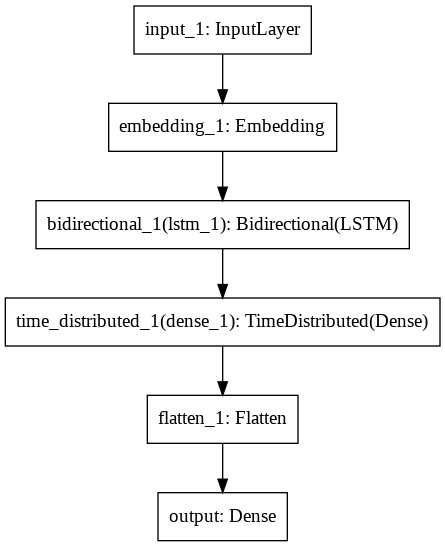

In [ ]:
if (apply_TPU_support):
  with tpu_strategy.scope():
    model = build_model()
else:
  model = build_model()
# model = stacked_RNN_model_3(LSTM, MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
plot_model(model,to_file="./model.png")

### Train Model

In [ ]:
# trained_model = Train_Model_old(model,X_train, X_test, y_train, y_test)
if (apply_TPU_support):

  trained_model, his = Train_Model(model, X_train, y_train, cross_validation = False)

  accuracy = his.history['accuracy']
  val_accuracy = his.history['val_accuracy']
  loss = his.history['loss']
  val_loss = his.history['val_loss']
  f1 = his.history['f1']
  val_f1 = his.history['f1']
  val_macro_f1 = his.history['val_macro_f1']

  Plot_graphs(accuracy,val_accuracy, "accuracy")
  Plot_graphs(loss,val_loss, "loss")
  Plot_graphs(f1, val_f1, "f1")

Training and Testing...
Class Distribution Without Oversampling [9898 1051]
Class Distribution After Oversampling [9898 4949]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)




Train on 14847 samples, validate on 1217 samples


KeyboardInterrupt: ignored

### Restart runtime and import Relibraries
There is a bug, if run time isn't restart after this point, It's going to malfunction.

In [ ]:
# #os.kill(os.getpid(), 9)
# exit()

In [ ]:
# from keras.models import Sequential,Model,load_model
# import pandas as pd
# import numpy as np
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,precision_recall_fscore_support

# experiment_no = 100
# model_name = "RNN"
# experiment_name = folder_path + "Sentiment Analysis/CNN RNN/experiments/" + model_name +str(experiment_no)+"_"+embedding_type+"_"+str(embedding_size)+"_"+str(context)

# model_save_path = folder_path + "Sentiment Analysis/CNN RNN/saved_models/weights_best_"+model_name+"_"+embedding_type+"_"+str(embedding_size)+"_"+str(experiment_no)+".hdf5"

### Test Model

#### Load Weights to Model

In [ ]:
model_save_path = folder_path + "Humor_HateSpeech detection/Implementation/saved_models/" + technique + "/"+ experiment_no +"_" + model_type + "_model_fasttext_300_5.hdf5"
# model_save_path = "/content/drive/Shareddrives/FYP/Humor_HateSpeech detection/Implementation/saved_models/hate speech/06_BiLSTM_model_fasttext_300_5.hdf5"

print("Load model from "+model_save_path)
loaded_model  = keras.models.load_model(model_save_path, custom_objects={"f1": f1}, compile=False)
print("loaded " + loaded_model.name)

# _, train_acc,train_f1 = loaded_model.evaluate(X_train, y_train, verbose=1)
# _, test_acc,test_f1= loaded_model.evaluate(X_test, y_test, verbose=1)
# print('Train_acc: %.3f, Test_acc: %.3f, Train_f1: %.3f,  Test_f1: %.3f' % (train_acc, test_acc,train_f1,test_f1))

Load model from /content/drive/Shareddrives/FYP/Humor_HateSpeech detection/Implementation/saved_models/humor/101_LSTM_model_fasttext_300_5.hdf5
loaded RNN_model


#### Get Predictions

In [ ]:
predictions = loaded_model.predict(X_test, batch_size=BATCH_SIZE, verbose=1)

labels = np.argmax(y_test, axis=1)
predictions = np.argmax(predictions, axis=1)

cm = confusion_matrix(labels,predictions )

# classification_report
report = classification_report(labels, predictions, digits=4,output_dict=True)
report_print = classification_report(labels, predictions, digits=4)
print(report_print)

# save report to drive
report_save_path = folder_path + "Humor_HateSpeech detection/Implementation/reports/"+model_name+"_"+technique+"_"+ experiment_no+"_report.csv"
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(report_save_path)

1352/1352 [==============================] - 23s 17ms/step
              precision    recall  f1-score   support

           0     0.4138    0.4511    0.4317       133
           1     0.9395    0.9303    0.9349      1219

    accuracy                         0.8831      1352
   macro avg     0.6767    0.6907    0.6833      1352
weighted avg     0.8878    0.8831    0.8854      1352



In [ ]:
train_data_original, test_data_original = train_test_split(all_data, test_size=0.1, random_state=0)

predictions_series = pd.Series(predictions)
predictions_1 = pd.get_dummies(predictions_series).idxmax(1)

In [ ]:
data_frame = pd.DataFrame({'Sentence': test_data_original['Sentence'], 'Label': test_data_original['Label'], 'Predictions': np.array(predictions_1)})

def apply_label_name(value):
  return tag_set[value]

data_frame["Predictions"] = data_frame["Predictions"].apply(apply_label_name)

prediction_save_name  = folder_path + "Humor_HateSpeech detection/Implementation/predictions/"+model_name+"_"+technique+"_"+ experiment_no+"_predictions_with_labels.csv"
data_frame.to_csv(prediction_save_name)
data_table.DataTable(data_frame, include_index=False, num_rows_per_page=10)

,Sentence,Label,Predictions
12114,මේක තමයි හොඳම වංචාව.,Non-humorous,Non-Humorous
3505,frree da,Non-humorous,Non-Humorous
13156,Alawwata gendoooo,Non-humorous,Non-Humorous
2364,Balummhara fiber diyan labba,Non-humorous,Non-Humorous
1136,Enjoy good times streaming with the Automatic ...,Non-humorous,Non-Humorous
...,...,...,...
9997,නැතහොත් SLT පාරිභෝගිකයන් ඉක්මනින් වෙනත් ආයතනයක...,Non-humorous,Non-Humorous
16,හොඳ වැඩේ....මෙයැයිලගේ හැටි දන්නෑ ඔයැයිලා....❤️...,Humorous,Humorous
578,Now I bought 1Gb but free 1 Gb is not there??,Non-humorous,Non-Humorous
2305,හරීම ලස්සනයි මෙහෙම හොද පුතාලත් ලෝකයේ ඉන්නවා,Non-humorous,Non-Humorous


### Print confusion matrix

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

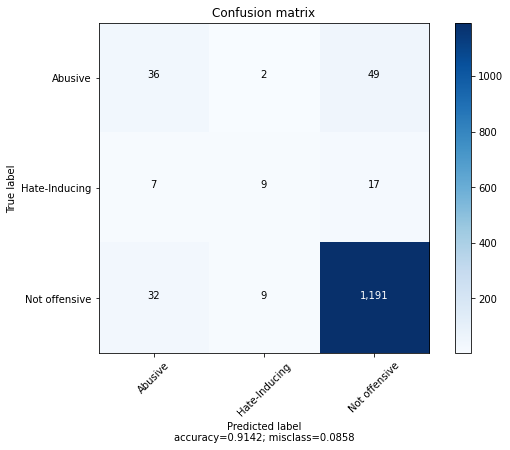

In [ ]:
if (technique=="humor"):
  plot_confusion_matrix(cm, ["Humorous","Non humorous"], normalize=False)
else:  
  plot_confusion_matrix(cm, ["Abusive","Hate-Inducing","Not offensive"], normalize=False)

## Train and Test Model (Cross Validation)

In [ ]:
with tpu_strategy.scope():
  Do_Cross_Validation(padded_docs, comment_labels)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
------------------------------------------------------------------------
Training for fold 1 ...
Training and Testing...
Class Distribution Without Oversampling [8825  233  674]
Class Distribution After Oversampling [8825 2206 2206]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)




Train on 13237 samples, validate on 1082 samples
Epoch 1/10
13237/13237 [==============================] - 895s 68ms/step - loss: 1.1960 - accuracy: 0.7481 - precision: 0.7595 - recall: 0.6448 - f1: 0.7389 - val_loss: 0.4737 - val_accuracy: 0.8863 - val_precision: 0.7930 - val_recall: 0.7065 - val_f1: 0.8894
val_macro_precision: 0.528878 - val_macro_recall: 0.567497 - val_macro_f1: 0.528089
Epoch 2/10
13237/13237 [==============================] - 891s 67ms/step - loss: 0.5985 - accuracy: 0.8089 - precision: 0.8053 - recall: 0.7308 - f1: 0.8050 - val_loss: 0.4718 - val_accuracy: 0.8771 - val_precision: 0.8152 - val_recall: 0.7484 - val_f1: 0.8756
val_macro_precision: 0.514811 - val_macro_recall: 0.595493 - val_macro_f1: 0.545556
Epoch 3/10
13237/13237 [==============================] - 894s 68ms/step - loss: 0.4989 - accuracy: 0.8515 - precision: 0.8250 - recall: 0.7642 - f1: 0.8498 - val_loss: 0.4068 - val_accuracy: 0.9030 - val_precision: 0.8338 - val_recall: 0.7786 - val_f1: 0.901

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Train on 13233 samples, validate on 1082 samples
Epoch 1/10
13233/13233 [==============================] - 907s 69ms/step - loss: 1.2232 - accuracy: 0.7474 - precision_1: 0.7707 - recall_1: 0.6491 - f1: 0.7359 - val_loss: 0.4385 - val_accuracy: 0.9168 - val_precision_1: 0.7957 - val_recall_1: 0.7019 - val_f1: 0.9181
val_macro_precision: 0.582734 - val_macro_recall: 0.457816 - val_macro_f1: 0.493421
Epoch 2/10
13233/13233 [==============================] - 906s 68ms/step - loss: 0.5989 - accuracy: 0.8109 - precision_1: 0.8102 - recall_1: 0.7279 - f1: 0.8062 - val_loss: 0.4331 - val_accuracy: 0.9002 - val_precision_1: 0.8201 - val_recall_1: 0.7461 - val_f1: 0.8950
val_macro_precision: 0.540729 - val_macro_recall: 0.558444 - val_macro_f1: 0.548798
Epoch 3/10
13233/13233 [==============================] - 909s 69ms/step - loss: 0.4957 - accuracy: 0.8507 - precision_1: 0.8301 - recall_1: 0.7629 - f1: 0.8491 - val_loss: 0.4560 - val_accuracy: 0.8835 - val_precision_1: 0.8375 - val_recall_1: 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Train on 13227 samples, validate on 1082 samples
Epoch 1/10
13227/13227 [==============================] - 921s 70ms/step - loss: 1.2321 - accuracy: 0.7430 - precision_2: 0.7538 - recall_2: 0.6245 - f1: 0.7293 - val_loss: 0.5948 - val_accuracy: 0.8364 - val_precision_2: 0.7869 - val_recall_2: 0.6922 - val_f1: 0.8217
val_macro_precision: 0.501359 - val_macro_recall: 0.683042 - val_macro_f1: 0.545362
Epoch 2/10
13227/13227 [==============================] - 918s 69ms/step - loss: 0.6240 - accuracy: 0.7947 - precision_2: 0.7986 - recall_2: 0.7142 - f1: 0.7921 - val_loss: 0.5672 - val_accuracy: 0.8438 - val_precision_2: 0.8071 - val_recall_2: 0.7304 - val_f1: 0.8384
val_macro_precision: 0.524133 - val_macro_recall: 0.724342 - val_macro_f1: 0.557763
Epoch 3/10
13227/13227 [==============================] - 922s 70ms/step - loss: 0.5164 - accuracy: 0.8400 - precision_2: 0.8168 - recall_2: 0.7464 - f1: 0.8381 - val_loss: 0.4158 - val_accuracy: 0.8956 - val_precision_2: 0.8257 - val_recall_2: 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Train on 13220 samples, validate on 1082 samples
Epoch 1/10
13220/13220 [==============================] - 937s 71ms/step - loss: 1.2542 - accuracy: 0.7430 - precision_3: 0.7542 - recall_3: 0.6322 - f1: 0.7310 - val_loss: 0.5098 - val_accuracy: 0.8799 - val_precision_3: 0.7886 - val_recall_3: 0.6957 - val_f1: 0.8845
val_macro_precision: 0.524220 - val_macro_recall: 0.519081 - val_macro_f1: 0.504689
Epoch 2/10
13220/13220 [==============================] - 934s 71ms/step - loss: 0.6102 - accuracy: 0.8073 - precision_3: 0.8051 - recall_3: 0.7221 - f1: 0.8021 - val_loss: 0.4666 - val_accuracy: 0.8845 - val_precision_3: 0.8148 - val_recall_3: 0.7389 - val_f1: 0.8876
val_macro_precision: 0.524917 - val_macro_recall: 0.577547 - val_macro_f1: 0.544550
Epoch 3/10
 6624/13220 [==============>...............] - ETA: 7:31 - loss: 0.5242 - accuracy: 0.8389 - precision_3: 0.8204 - recall_3: 0.7484 - f1: 0.8355

# Hyperparameter Tuning

In [ ]:
import hyperopt
from hyperopt import hp, tpe, fmin, STATUS_OK, Trials
import warnings
from csv import writer

# fix random seed for reproducibility
np.random.seed(7)
warnings.filterwarnings("ignore")

# def f1_macro(y, y_pred, **kwargs):
#     return f1_score(np.argmax(y, axis=1), y_pred, **kwargs)

space = {
    # 'learning_rate': hp.choice('learning_rate', [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.95]), # 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95
    'drop_out_value_1': hp.choice('drop_out_value_1', [0.3, 0.5, 0.8]), 
    # 'drop_out_value_2': hp.choice('drop_out_value_2', [0.3, 0.5, 0.8]),
    'l2_reg': hp.choice('l2_reg', [0.0001, 0.001, 0.01]),
    'hidden_dims': hp.choice('hidden_dims', [300, 400, 500, 600]),
    'optimizer': hp.choice('optimizer', ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'])
}

x_train, x_test, y_train, y_test = train_test_split(padded_docs, comment_labels, test_size=VALIDATION_SPLIT*2, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=VALIDATION_SPLIT, random_state=0)
X_over, y_over = apply_oversampling(x_train, y_train);

trials = Trials()

def objective(params):

    print({'params': params})

    # ------------------------------------------------------- Without Cross Validation -------------------------------------------------------
    es = EarlyStopping(monitor='val_macro_f1', mode='max', verbose=1, patience=5)
    callbacks_list = [MacroMetrics(valid_data=(x_val, y_val)), es]

    with tpu_strategy.scope(): 
        model = BiLSTM_model(MAX_LEN, params['hidden_dims'], params['l2_reg'], params['drop_out_value_1'], params['optimizer'])
        # model = RNN_model(LSTM, MAX_LEN, params['hidden_dims'], L2_REG, params['drop_out_value_1'], params['drop_out_value_2'], params['optimizer'], params['learning_rate'])
        # model = RNN_model(LSTM, MAX_LEN, params['hidden_dims'], L2_REG, params['drop_out_value_1'], params['drop_out_value_2'], params['optimizer']) #  params['learning_rate']
        his = model.fit(X_over, y_over, validation_data=[x_val, y_val], epochs=10, batch_size=BATCH_SIZE, verbose=1, callbacks=callbacks_list)
        predictions = model.predict(x_test, batch_size=BATCH_SIZE, verbose=1)
        predictions = (np.asarray(predictions)).round()
        if (np.isnan(predictions).any()):
            result = 0
        else:
            result = f1_score(y_test, predictions, average='macro') # returns macro_f1
    
    # ------------------------------------------------------- With Cross Validation -------------------------------------------------------
    # model = KerasClassifier(build_fn=RNN_model, RNN_layer=LSTM, maxlen=MAX_LEN, hidden_dims=params['hidden_dims'], l2_reg=L2_REG, drop_out_value_1=params['drop_out_value_1'], drop_out_value_2=params['drop_out_value_2'], optimizer=params['optimizer'], learning_rate=params['learning_rate'])
    # with tpu_strategy.scope():
    #   result = cross_val_score(model, padded_docs, comment_labels, scoring=make_scorer(f1_macro, average="macro"), cv=5, verbose=1, n_jobs=1).mean()

    ret = {'loss': - result,'params': params, 'status': STATUS_OK}
    with open('/content/drive/Shareddrives/FYP/optimize/result_hate_2.csv', 'a') as f_object:
      writer_object = writer(f_object)
      writer_object.writerow([
        ret["loss"], 
        ret["params"]["drop_out_value_1"],
        ret["params"]["l2_reg"],
        ret["params"]["hidden_dims"],
        ret["params"]["optimizer"]
        ])
      f_object.close()
    print("Current Trial", ret)
    print("Completed Trials:", trials.results)

    return ret

Class Distribution Without Oversampling [8808  247  677]
Class Distribution After Oversampling [8808 2202 2202]


In [ ]:
# Run optimization - Random search.
def tune_hyperparameres():
  best = fmin(
      fn = objective, 
      space = space, 
      algo = tpe.rand.suggest,
      max_evals = 1, 
      trials = trials, 
      verbose = 0
  )
  print(best)
  print(hyperopt.space_eval(space, best))

In [ ]:
tune_hyperparameres()

{'params': {'drop_out_value_1': 0.3, 'hidden_dims': 300, 'l2_reg': 0.01, 'optimizer': 'Adamax'}}
Train on 13212 samples, validate on 1082 samples
Epoch 1/10
   32/13212 [..............................]
 - ETA: 21:32 - loss: 10.6858 - accuracy: 0.2500 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - f1: 0.0000e+00

   64/13212 [..............................]
 - ETA: 18:07 - loss: 10.1141 - accuracy: 0.4688 - precision_6: 0.3529 - recall_6: 0.0938 - f1: 0.2449            

   96/13212 [..............................]
 - ETA: 17:04 - loss: 9.9108 - accuracy: 0.5104 - precision_6: 0.4462 - recall_6: 0.1701 - f1: 0.3612 


KeyboardInterrupt: ignored

In [ ]:
trials.results

[{'loss': -0.6918542632731925,
  'params': {'drop_out_value_1': 0.5,
   'hidden_dims': 300,
   'l2_reg': 0.002,
   'optimizer': 'Adam'},
  'status': 'ok'}]